# MC855 -  Atividade 1 

## Analise Exploratoria e Pre-Processamento do Dataset  

Lucas Xavier do Passo Suaide 182278

Arthur Rezende Salles da Costa 166003

Marcio Aparecido de Godoi Junior 252667



In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import pandas as pd 
import shutil
from sklearn.model_selection import train_test_split

plt.style.use('ggplot')

NON_CARDIO = ['Adductor' ,'ArmCurl' ,'BenchPress' ,'LegCurl' ,'LegPress', 'Squat' ]
CARDIO = ['Riding', 'RopeSkipping' ,'Running', 'StairClimber', 'Walking']
ALL_WORKOUTS = NON_CARDIO + CARDIO

LABELS = {'CARDIO' : 1 , 'NON_CARDIO' :0}
WORKOUT_TO_LABEL = {ex : i for i, ex in enumerate(ALL_WORKOUTS)}
WANTED_COLS = ['A_x','A_y','A_z','G_x','G_y','G_z','C_1','label']


In [2]:
raw_data = pd.read_csv("../data/RecGym.csv")
print(raw_data.dtypes)
print(raw_data.shape)
raw_data.head()

Subject       int64
Position     object
Session       int64
A_x         float64
A_y         float64
A_z         float64
G_x         float64
G_y         float64
G_z         float64
C_1         float64
Workout      object
dtype: object
(4703320, 11)


,Subject,Position,Session,A_x,A_y,A_z,G_x,G_y,G_z,C_1,Workout
0,1,wrist,1,0.501125,0.500625,0.500500,0.500156,0.499962,0.500313,0.501227,Null
1,1,wrist,1,0.500250,0.499750,0.501250,0.499531,0.500550,0.500081,0.501584,Null
2,1,wrist,1,0.500250,0.499375,0.501875,0.499613,0.500231,0.500119,0.501508,Null
3,1,wrist,1,0.499625,0.499750,0.500875,0.499494,0.500350,0.500588,0.502032,Null
4,1,wrist,1,0.500000,0.499000,0.501000,0.499650,0.500588,0.499769,0.501756,Null


In [3]:
# Removing null entries 
raw_data['Workout'] = raw_data['Workout'].replace(to_replace='Null', value=None)
raw_data.dropna(inplace=True)

# printing all options for the dataset
for c in ['Subject', 'Position', 'Session', 'Workout']:
    print(f"{c} : {np.unique(raw_data[c].values)}, size : {len(np.unique(raw_data[c].values))}")

print("--" * 40)
print("cardio exercises :",CARDIO)
print("non cardio exercises :", NON_CARDIO)
print("--" * 40)

# generating binary labels 
raw_data['label'] = np.where(raw_data['Workout'].isin(CARDIO), 1, 0)
raw_data['str-label'] = np.where(raw_data['Workout'].isin(CARDIO), 'CARDIO', 'NON_CARDIO')

Subject : [ 1  2  3  4  5  6  7  8  9 10], size : 10
Position : ['leg' 'pocket' 'wrist'], size : 3
Session : [1 2 3 4 5], size : 5
Workout : ['Adductor' 'ArmCurl' 'BenchPress' 'LegCurl' 'LegPress' 'Riding'
 'RopeSkipping' 'Running' 'Squat' 'StairClimber' 'Walking'], size : 11
--------------------------------------------------------------------------------
cardio exercises : ['Riding', 'RopeSkipping', 'Running', 'StairClimber', 'Walking']
non cardio exercises : ['Adductor', 'ArmCurl', 'BenchPress', 'LegCurl', 'LegPress', 'Squat']
--------------------------------------------------------------------------------


###  Sanity Check on the data

checking if each session has all the exercises and all sensors

In [4]:
df_view = raw_data[['Subject', 'Session', 'Workout', 'Position', 'str-label']]
df_view = df_view.drop_duplicates()

valid_positions = np.unique(raw_data['Position'].values)

pos_available = (
    df_view.assign(val=True).pivot_table(index=['Subject', 'Session', 'Workout'],
                                        columns='Position',
                                        values="val",  fill_value=0).reset_index()
)

# checking each sensor 
for sensor in ['leg', 'pocket', 'wrist']:
    query = f"{sensor} == 0"
    df = pos_available.query(query)
    print(f"Sensor evaluated : {sensor} - Missing Samples : {len(df)}")
    display(df)



Sensor evaluated : leg - Missing Samples : 57


Position,Subject,Session,Workout,leg,pocket,wrist
11,1,2,Adductor,0.0,1.0,1.0
12,1,2,ArmCurl,0.0,1.0,1.0
13,1,2,BenchPress,0.0,1.0,1.0
14,1,2,LegCurl,0.0,1.0,1.0
15,1,2,LegPress,0.0,1.0,1.0
16,1,2,Riding,0.0,1.0,1.0
17,1,2,RopeSkipping,0.0,1.0,1.0
18,1,2,Running,0.0,1.0,1.0
19,1,2,Squat,0.0,1.0,1.0
20,1,2,StairClimber,0.0,1.0,1.0


Sensor evaluated : pocket - Missing Samples : 5


Position,Subject,Session,Workout,leg,pocket,wrist
166,4,1,BenchPress,1.0,0.0,1.0
233,5,2,Riding,1.0,0.0,1.0
235,5,2,Running,1.0,0.0,1.0
237,5,2,StairClimber,1.0,0.0,1.0
238,5,2,Walking,1.0,0.0,1.0


Sensor evaluated : wrist - Missing Samples : 1


Position,Subject,Session,Workout,leg,pocket,wrist
439,9,1,LegCurl,0.0,1.0,0.0


We will use only the `wrist` sensor. Since is the most feasible one for real life applications and also is the most present one

### Split data into two types :

.   LOSO : Leave One Subject Out

.   70 / 20 / 10 : Training, Validation and Test

.   Time Validation : all samples from T1 to T3 as Training, T4 Validation and T5 to test


In [5]:
class RecGymLoader(): 
    
    def __init__(self, data_folder= '../data/processed/subjects', random_seed=855):

        self.random_seed = random_seed
        self.data_folder = data_folder
        self.save_folder = '/'.join(data_folder.split('/')[:-1])
        self.__prepare_folders()

    def __prepare_folders(self):
        data_path = "../data"
        self.base_path = os.path.join(data_path, "processed/subjects")

        if not os.path.isdir(self.base_path):
            os.makedirs(self.base_path)

        for (subject, session, exercise, pos, str_label), data in raw_data.groupby(by=['Subject', 'Session', 'Workout', 'Position' ,'str-label']):

            sub_path = os.path.join(self.base_path, f"subject_{subject}")
            if not os.path.isdir(sub_path):
                os.mkdir(sub_path)

            cardio_path = os.path.join(sub_path, f"{str_label}")
            if not os.path.isdir(cardio_path):
                os.mkdir(cardio_path)
            
            sub_session = os.path.join(cardio_path,f"session_{session}" )
            if not os.path.isdir(sub_session):
                os.mkdir(sub_session)
            
            file_path = os.path.join(sub_session, f"{exercise}_{pos}")
            data.to_csv(file_path + ".csv")

    def __read_data_default(self, subject_pool, split_type):
        
        losodata = []
        txdata = []

        sample_number = 0
        
        for i, tx_subject in enumerate(subject_pool): 

            if split_type == 'loso':
                txdata, txlabel = [], []

            cd_path = os.path.join(self.data_folder, f"subject_{tx_subject}/CARDIO")
            non_cd_path = os.path.join(self.data_folder, f"subject_{tx_subject}/NON_CARDIO")

            cardio_path = [os.path.join(cd_path, session_id) for session_id in os.listdir(cd_path)]
            non_cardio_path = [os.path.join(non_cd_path, session_id) for session_id in os.listdir(non_cd_path)]

            for j, tt in enumerate([cardio_path, non_cardio_path]):
                for k, session in enumerate(tt):
                    wrist_files = [a for a in filter(lambda x : 'wrist' in x , [os.path.join(session, a) for a in os.listdir(session)])]
                    for l , file in enumerate(wrist_files):
                        df = pd.read_csv(file)
                        subject, session_number, label, workout = df['Subject'][0], df['Session'][0], df['label'][0], df['Workout'][0]
                        multiclass_label = WORKOUT_TO_LABEL[workout]
                        df = df[WANTED_COLS]
                        df['sample'] = sample_number
                        df['Workout'] = workout
                        txdata.append(df) ###  ACCX...Z, GYRX...Z, Body Capacitance, sample_number ### -> sample number will be used to split back the data
                        sample_number += 1 

            losodata.append(txdata)

        return txdata if split_type != 'loso' else losodata
    

    def default_split(self):

        training_indexes, temp_indexes = train_test_split(range(1, 11), train_size=0.7, random_state=self.random_seed)
        validation_indexes, test_indexes = train_test_split(temp_indexes, test_size=0.3, random_state=int(self.random_seed * 0.5))

        train_data = self.__read_data_default(training_indexes, 'default')
        val_data = self.__read_data_default(validation_indexes, 'default')
        test_data = self.__read_data_default(test_indexes, 'default')

        default_path = os.path.join(self.save_folder, 'final/train_val_test') 
        if not os.path.isdir(default_path):
            os.makedirs(default_path)

        pd.concat(train_data).to_csv(os.path.join(default_path, 'train_data.csv'), index=False)
        pd.concat(val_data).to_csv(os.path.join(default_path, 'validation_data.csv'), index=False)
        pd.concat(test_data).to_csv(os.path.join(default_path, 'test_data.csv'), index=False)

        print(f'Data saved as numpy array at:{default_path}')

        # cleaning folder tree
        shutil.rmtree(self.base_path)

        return train_data, val_data, test_data 
    
    def loso_split(self):

        pass

In [6]:
r = RecGymLoader()
train_data, val_data, test_data  = r.default_split()

Data saved as numpy array at:../data/processed/final/train_val_test


In [7]:
def get_label(data):
    y = []
    for df in data:
        y.append(df['label'][0])
    return np.array(y) 

train_label = get_label(train_data)
val_label = get_label(val_data)
test_label = get_label(test_data)


In [8]:
df_counter = df_view[df_view['Position'] == 'wrist']

original_dist = dict(df_counter.groupby('Workout').count()['str-label'])
binary_dist = dict(df_counter.groupby('str-label').count()['Subject'])
subject_dist = df_counter.groupby(['Subject', 'str-label']).count()['Session']


## checking incomplete data

In [9]:
10 * 11 * 5

550

In [10]:
df_counter.groupby('Subject').count()

,Session,Workout,Position,str-label
Subject,,,,
1,55,55,55,55
2,55,55,55,55
3,55,55,55,55
4,52,52,52,52
5,55,55,55,55
6,54,54,54,54
7,55,55,55,55
8,55,55,55,55
9,54,54,54,54


missing samples on subjects : 4 ( 3 sumidas), 9 (1 nao coletada ), 6 (1 sample)

In [11]:
df_cnt = df_counter[df_counter.Subject.isin([4, 6])]

for (sub, ex), df in df_cnt.groupby(['Subject', 'Workout']):
    display(df)

,Subject,Session,Workout,Position,str-label
547294,4,1,Adductor,wrist,NON_CARDIO
554817,4,2,Adductor,wrist,NON_CARDIO
594716,4,3,Adductor,wrist,NON_CARDIO
623216,4,4,Adductor,wrist,NON_CARDIO
652967,4,5,Adductor,wrist,NON_CARDIO


,Subject,Session,Workout,Position,str-label
560435,4,2,ArmCurl,wrist,NON_CARDIO
591401,4,3,ArmCurl,wrist,NON_CARDIO
620319,4,4,ArmCurl,wrist,NON_CARDIO
649849,4,5,ArmCurl,wrist,NON_CARDIO


,Subject,Session,Workout,Position,str-label
513798,4,1,BenchPress,wrist,NON_CARDIO
567457,4,2,BenchPress,wrist,NON_CARDIO
600741,4,3,BenchPress,wrist,NON_CARDIO
628029,4,4,BenchPress,wrist,NON_CARDIO
656158,4,5,BenchPress,wrist,NON_CARDIO


,Subject,Session,Workout,Position,str-label
544890,4,1,LegCurl,wrist,NON_CARDIO
551593,4,2,LegCurl,wrist,NON_CARDIO
588563,4,3,LegCurl,wrist,NON_CARDIO
617636,4,4,LegCurl,wrist,NON_CARDIO
647308,4,5,LegCurl,wrist,NON_CARDIO


,Subject,Session,Workout,Position,str-label
508999,4,1,LegPress,wrist,NON_CARDIO
557821,4,2,LegPress,wrist,NON_CARDIO
596919,4,3,LegPress,wrist,NON_CARDIO
625184,4,4,LegPress,wrist,NON_CARDIO
658470,4,5,LegPress,wrist,NON_CARDIO


,Subject,Session,Workout,Position,str-label
542071,4,1,Riding,wrist,CARDIO
612129,4,3,Riding,wrist,CARDIO
641957,4,4,Riding,wrist,CARDIO
671004,4,5,Riding,wrist,CARDIO


,Subject,Session,Workout,Position,str-label
570458,4,2,RopeSkipping,wrist,CARDIO
602977,4,3,RopeSkipping,wrist,CARDIO
631753,4,4,RopeSkipping,wrist,CARDIO
662252,4,5,RopeSkipping,wrist,CARDIO


,Subject,Session,Workout,Position,str-label
536197,4,1,Running,wrist,CARDIO
577401,4,2,Running,wrist,CARDIO
610250,4,3,Running,wrist,CARDIO
637230,4,4,Running,wrist,CARDIO
667315,4,5,Running,wrist,CARDIO


,Subject,Session,Workout,Position,str-label
507130,4,1,Squat,wrist,NON_CARDIO
552771,4,2,Squat,wrist,NON_CARDIO
589577,4,3,Squat,wrist,NON_CARDIO
618699,4,4,Squat,wrist,NON_CARDIO
648182,4,5,Squat,wrist,NON_CARDIO


,Subject,Session,Workout,Position,str-label
538709,4,1,StairClimber,wrist,CARDIO
580003,4,2,StairClimber,wrist,CARDIO
605013,4,3,StairClimber,wrist,CARDIO
639162,4,4,StairClimber,wrist,CARDIO
668884,4,5,StairClimber,wrist,CARDIO


,Subject,Session,Workout,Position,str-label
523161,4,1,Walking,wrist,CARDIO
573485,4,2,Walking,wrist,CARDIO
607862,4,3,Walking,wrist,CARDIO
633998,4,4,Walking,wrist,CARDIO
664621,4,5,Walking,wrist,CARDIO


,Subject,Session,Workout,Position,str-label
839870,6,1,Adductor,wrist,NON_CARDIO
879420,6,2,Adductor,wrist,NON_CARDIO
948381,6,3,Adductor,wrist,NON_CARDIO
970477,6,4,Adductor,wrist,NON_CARDIO
997236,6,5,Adductor,wrist,NON_CARDIO


,Subject,Session,Workout,Position,str-label
887574,6,2,ArmCurl,wrist,NON_CARDIO
927609,6,3,ArmCurl,wrist,NON_CARDIO
972724,6,4,ArmCurl,wrist,NON_CARDIO
994134,6,5,ArmCurl,wrist,NON_CARDIO


,Subject,Session,Workout,Position,str-label
843761,6,1,BenchPress,wrist,NON_CARDIO
894450,6,2,BenchPress,wrist,NON_CARDIO
931176,6,3,BenchPress,wrist,NON_CARDIO
975495,6,4,BenchPress,wrist,NON_CARDIO
999540,6,5,BenchPress,wrist,NON_CARDIO


,Subject,Session,Workout,Position,str-label
836589,6,1,LegCurl,wrist,NON_CARDIO
874363,6,2,LegCurl,wrist,NON_CARDIO
922625,6,3,LegCurl,wrist,NON_CARDIO
956016,6,4,LegCurl,wrist,NON_CARDIO
992019,6,5,LegCurl,wrist,NON_CARDIO


,Subject,Session,Workout,Position,str-label
861589,6,1,LegPress,wrist,NON_CARDIO
882347,6,2,LegPress,wrist,NON_CARDIO
925520,6,3,LegPress,wrist,NON_CARDIO
978926,6,4,LegPress,wrist,NON_CARDIO
1002136,6,5,LegPress,wrist,NON_CARDIO


,Subject,Session,Workout,Position,str-label
856245,6,1,Riding,wrist,CARDIO
917995,6,2,Riding,wrist,CARDIO
950977,6,3,Riding,wrist,CARDIO
968208,6,4,Riding,wrist,CARDIO
1012628,6,5,Riding,wrist,CARDIO


,Subject,Session,Workout,Position,str-label
868609,6,1,RopeSkipping,wrist,CARDIO
898186,6,2,RopeSkipping,wrist,CARDIO
934767,6,3,RopeSkipping,wrist,CARDIO
958666,6,4,RopeSkipping,wrist,CARDIO
1003579,6,5,RopeSkipping,wrist,CARDIO


,Subject,Session,Workout,Position,str-label
851117,6,1,Running,wrist,CARDIO
910548,6,2,Running,wrist,CARDIO
943368,6,3,Running,wrist,CARDIO
963120,6,4,Running,wrist,CARDIO
1007603,6,5,Running,wrist,CARDIO


,Subject,Session,Workout,Position,str-label
834911,6,1,Squat,wrist,NON_CARDIO
875942,6,2,Squat,wrist,NON_CARDIO
923701,6,3,Squat,wrist,NON_CARDIO
956872,6,4,Squat,wrist,NON_CARDIO
992720,6,5,Squat,wrist,NON_CARDIO


,Subject,Session,Workout,Position,str-label
853349,6,1,StairClimber,wrist,CARDIO
912936,6,2,StairClimber,wrist,CARDIO
945330,6,3,StairClimber,wrist,CARDIO
965300,6,4,StairClimber,wrist,CARDIO
1010064,6,5,StairClimber,wrist,CARDIO


,Subject,Session,Workout,Position,str-label
847752,6,1,Walking,wrist,CARDIO
906922,6,2,Walking,wrist,CARDIO
938874,6,3,Walking,wrist,CARDIO
960490,6,4,Walking,wrist,CARDIO
1005241,6,5,Walking,wrist,CARDIO


## plots

/tmp/ipykernel_6803/709183528.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][0].set_xticklabels(labels=original_dist ,size=10, rotation=45)
/tmp/ipykernel_6803/709183528.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0][1].set_xticklabels(labels=['CARDIO', 'NON_CARDIO'], size=14)
/tmp/ipykernel_6803/709183528.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


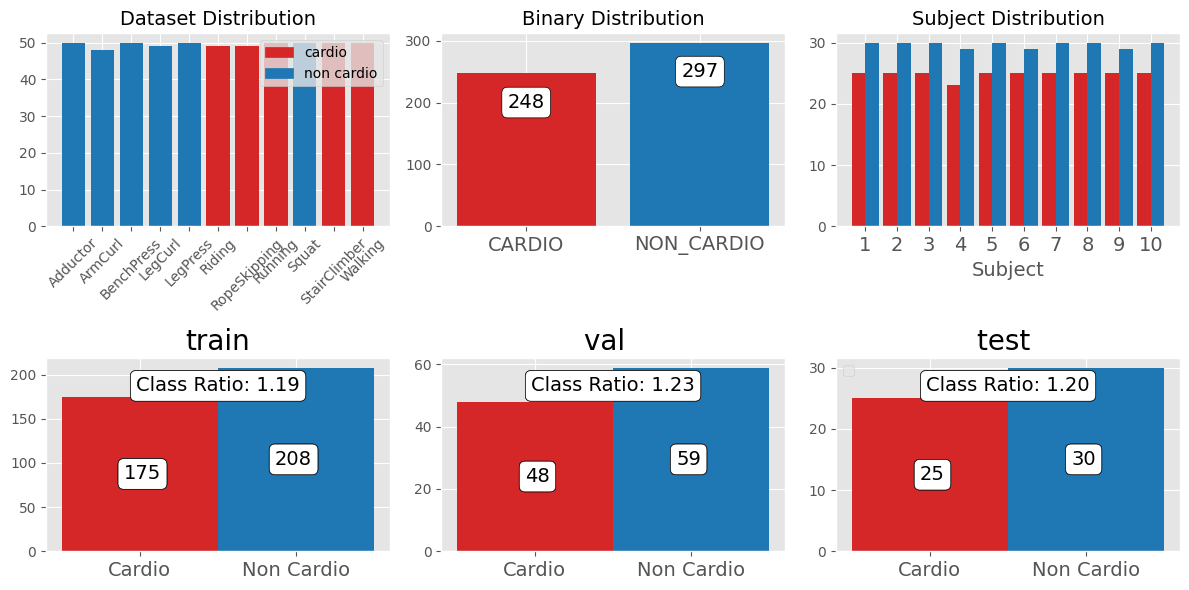

In [12]:


# original_dist
colors = ['tab:blue' if key in NON_CARDIO else 'tab:red' for key in original_dist]

red_patch = mpatches.Patch(color='tab:red', label='cardio')
blue_patch = mpatches.Patch(color='tab:blue', label='non cardio')


fig, ax = plt.subplots(2,3, figsize=(12,6))

#fig.suptitle('Class distribution for wrist only data')

ax[0][0].set_title('Dataset Distribution', size=14)
ax[0][0].bar(original_dist.keys(), original_dist.values(), color=colors)
# ax[0][0].tick_params(rotation=45,size=8)
ax[0][0].set_xticklabels(labels=original_dist ,size=10, rotation=45)

ax[0][0].legend(handles=[red_patch, blue_patch])


ax[0][1].set_title('Binary Distribution', size=14)
ax[0][1].bar(binary_dist.keys(), binary_dist.values(), color=['tab:red', 'tab:blue'])
ax[0][1].set_xticklabels(labels=['CARDIO', 'NON_CARDIO'], size=14)



ax[0][1].text(0, 200, binary_dist['CARDIO'], size=14,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(0, 0, 0),
                   fc=(1, 1, 1),
                   )
         )

ax[0][1].text(1, 250, binary_dist['NON_CARDIO'], size=14,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(0, 0, 0),
                   fc=(1, 1, 1),
                   )
            )

# subject distribution  
width = 0.6

x = np.arange(10) * (1 + .4)

cardio = np.array([subject_dist[i]['CARDIO'] for i in range(1, 11)])
non_cardio = np.array([subject_dist[i]['NON_CARDIO'] for i in range(1, 11)])

ax[0][2].set_title('Subject Distribution', size = 14)

ax[0][2].bar(x - width/2, cardio, width, label="cardio", color='tab:red')
ax[0][2].bar(x + width/2, non_cardio, width, label="non cardio", color='tab:blue')
ax[0][2].set_xticks(x)
ax[0][2].set_xticklabels(range(1, 11), size=14)
ax[0][2].set_xlabel('Subject', size=14)

plt.legend()

plt.tight_layout()
# plt.show()




### exploring data statistics on Default split technique 

x = {'train' : train_data, 'val  ' : val_data, 'test ': test_data}
y = {'train' : train_label, 'val  ' : val_label, 'test ': test_label}

#fig, ax = plt.subplots(1,3, figsize=(12,6))

plot_guide = np.arange(1) * (1 + .4)

# 1 is cardio, 0 is non cardio
for inx, (key, values) in enumerate(y.items()):
    y1, y2 = len(values[values == 1]), len(values[values == 0])

### exploring data statistics on Default split technique 

x = {'train' : train_data, 'val  ' : val_data, 'test ': test_data}
y = {'train' : train_label, 'val  ' : val_label, 'test ': test_label}


plot_guide = np.arange(1) * (1 + .4)

# 1 is cardio, 0 is non cardio
for inx, (key, values) in enumerate(y.items()):
    y1, y2 = len(values[values == 1]), len(values[values == 0])
    ax[1][inx].bar(plot_guide - width/2, y1, width, label="cardio", color='tab:red')
    ax[1][inx].bar(plot_guide + width/2, y2, width, label="non cardio", color='tab:blue')
    ax[1][inx].set_title(key, size=20)

    ax[1][inx].text(0, y2 *0.9, f'Class Ratio: {y2/y1:.2f}', size=14,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(0, 0, 0),
                   fc=(1, 1, 1),
                   ),
        )

    ax[1][inx].text(-.29, y1 * 0.5, y1, size=14,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(0, 0, 0),
                   fc=(1, 1, 1),
                   )
        )

    ax[1][inx].text(.29, y2*0.5, y2, size=14,
            ha="center", va="center",
            bbox=dict(boxstyle="round",
                    ec=(0, 0, 0),
                    fc=(1, 1, 1),
                    )
        )
    

    ax[1][inx].set_xticks([-.3, .3])
    #ax[inx].set(xticklabels=['Cardio', 'Non Cardio'])
    ax[1][inx].set_xticklabels(labels=['Cardio', 'Non Cardio'],size=14)
    ax[1][inx].set_title(key, size=20)

    ax[1][inx].text(0, y2 *0.9, f'Class Ratio: {y2/y1:.2f}', size=14,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(0, 0, 0),
                   fc=(1, 1, 1),
                   ),
        )

    ax[1][inx].text(-.29, y1 * 0.5, y1, size=14,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(0, 0, 0),
                   fc=(1, 1, 1),
                   )
        )

    ax[1][inx].text(.29, y2*0.5, y2, size=14,
            ha="center", va="center",
            bbox=dict(boxstyle="round",
                    ec=(0, 0, 0),
                    fc=(1, 1, 1),
                    )
        )
    

    ax[1][inx].set_xticks([-.3, .3])
    #ax[inx].set(xticklabels=['Cardio', 'Non Cardio'])
    ax[1][inx].set_xticklabels(labels=['Cardio', 'Non Cardio'],size=14)

plt.tight_layout()
plt.show()


/tmp/ipykernel_6803/2318051419.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[inx].set_yticklabels(range(-50, 251, 50), size=20)
/tmp/ipykernel_6803/2318051419.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[inx].set_yticklabels(range(-50, 251, 50), size=20)
/tmp/ipykernel_6803/2318051419.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[inx].set_yticklabels(range(-50, 251, 50), size=20)


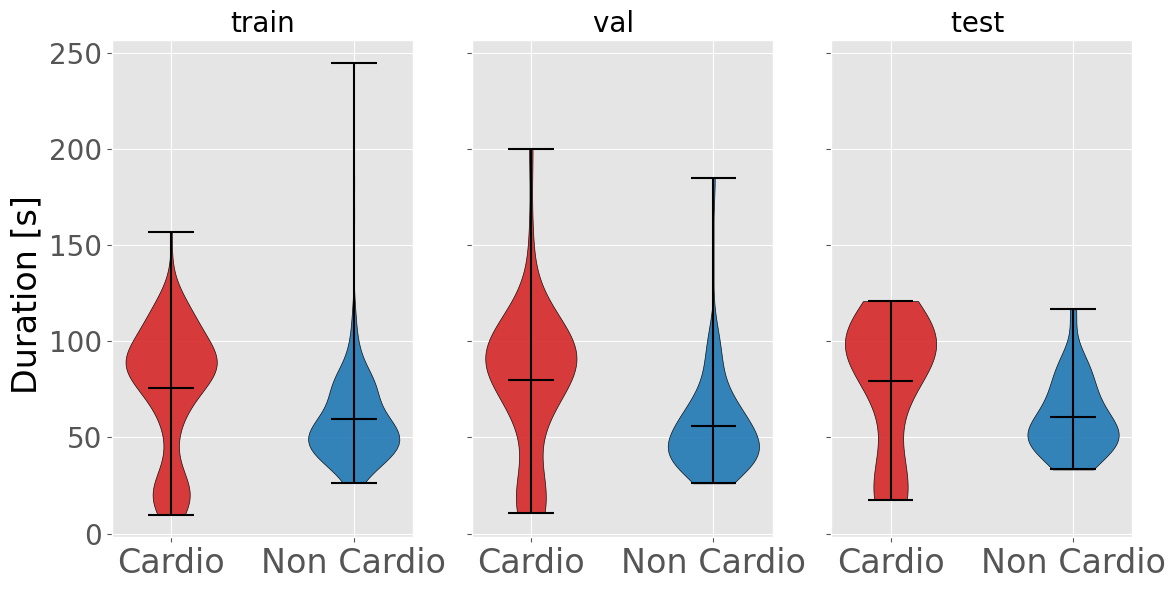

In [13]:
sizes = {'train' : np.array([t.shape[0] for t in train_data ]), 'val  ' : np.array([t.shape[0] for t in val_data ]), 'test ':np.array([ t.shape[0] for t in test_data ])}
fig, ax = plt.subplots(1,3, figsize=(12,6),sharey=True)

#fig.suptitle('Exercise Duration Distribution', fontsize=22)

fig.supylabel('Duration [s]', size=24)

for inx, (key, values) in enumerate(y.items()):
    sz_cardio, sz_non_cardio = sizes[key][values == 1], sizes[key][values == 0]

    parts = ax[inx].violinplot([sz_cardio * (1/20), sz_non_cardio * (1/20)],  showmeans=True)
    ax[inx].set_title(key, size=20)

    ax[inx].set_xticks([1,2])
    ax[inx].set_xticklabels(['Cardio', 'Non Cardio'], size=24) 
    ax[inx].set_yticklabels(range(-50, 251, 50), size=20)

    colors = ["tab:red", "tab:blue"]
    for body, color in zip(parts['bodies'], colors):
        body.set_facecolor(color)
        body.set_edgecolor("black")
        body.set_alpha(.9)

    for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
        if partname in parts:
            vp = parts[partname]
            vp.set_edgecolor("black")
            # vp.set_linewidth(0.8)

    # ax[inx].set
    # ax[inx].tick_params(bottom=False)  

fig.tight_layout()


In [14]:
def recover_data_from_df(csv_path= "../data/processed/final/train_val_test"):

    data_splits = {t.split('.')[0] : t for t in os.listdir(csv_path)}
    final_data = {key : [] for key in data_splits}
    final_targets = {key : [] for key in data_splits}

    for dt, dpath in data_splits.items(): 
        final_path = os.path.join(csv_path, dpath)

        for sample, df in pd.read_csv(final_path).groupby('sample'):
            
            label = df['label'].iloc[0]
            df.drop(columns=['sample', 'label'], inplace=True)
            final_data[dt].append(df.T.values)
            final_targets[dt].append(label)

        final_targets[dt] = np.array(final_targets[dt])

    return final_data, final_targets


ft, fy = recover_data_from_df()